In [1]:
!pip install --upgrade tensorflow # ставим последнюю версию tensorflow
!pip install keras # установка frontend-части
!pip install keras-cv # расширение фронта пакетом для компьютерного зрения

ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'
ERROR: Invalid requirement: '#'


In [2]:
import os # импорт библиотеки работы с системными переменными
# JAX - это высокопроизводительная библиотека для машинного обучения, компилирующая Python-код в машинный код для ускорения выполнения.
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data # модуль работы с данными
import tensorflow_datasets as tfds # TFDS предоставляет доступ к различным наборам данных
import keras # библиотеку Keras
import keras_cv # утилиты и модели для компьютерного зрения
import numpy as np # массивы и матрицы
from keras_cv import bounding_box # для объектных рамок
from keras_cv import visualization #  визуализации результатов работы моделей компьютерного зрения
import tqdm # прогресс-бары в циклах итерации

In [3]:
# в переменную pretrained_model загружается предобученная модель по обнаружению объектов YOLOV8Detector
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # параметры модели, оптимизированные для обнаружения объектов в наборе данных Pascal VOC
    bounding_box_format="xywh" # формат объектных рамок
)

In [4]:
type(pretrained_model)

keras_cv.src.models.object_detection.yolo_v8.yolo_v8_detector.YOLOV8Detector

(372, 490, 3)


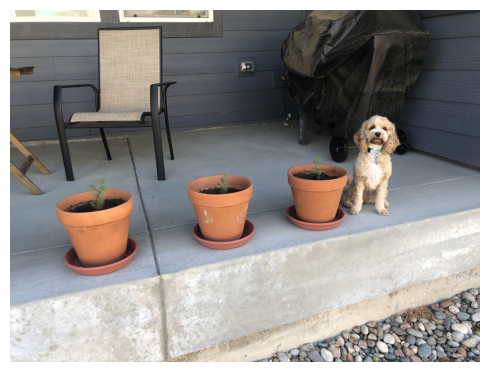

In [5]:
# путь к картинке

# Может возникнуть ошибка 429 при попытке загрузить
# картинку, если на нем установлены ограничения
# на количество скачиваний, нужно выбрать другой источник
# для скачивания изображения
filepath = keras.utils.get_file(origin="https://keras.io/img/guides/object_detection_keras_cv/object_detection_keras_cv_8_0.png")
image_png = keras.utils.load_img(filepath) # загружаем картинку в память
image = np.array(image_png)
# Далее закоментировал код, что бы выводилась одна картинка, а не две, часть кода излишняя
# visualization.plot_image_gallery(
#     np.array([image]),  # преобразуем картинку в массив
#     value_range=(0, 255), # диапазон значений пикселей
#     rows=0,
#     cols=0,
#     scale=5, # масштаб
# )
print(image.shape) # вывод формы матрицы
image_png # вывод, загруженной картинки

In [6]:
inference_resizing = keras_cv.layers.Resizing( # предпроцессный слой служит для изменения размера
    640, # желаемая высота картинки в пикселях
    640, # желаемая ширина картинки в пикселях
    pad_to_aspect_ratio=True, # прибавить пустоту для соблюдения пропорций
    bounding_box_format="xywh" # формат объектных рамок
)

In [7]:
# методу inference_resizing() передаем картинку в виде тензора, обратно получаем обработанный тензор
image_batch = inference_resizing([image])
type(image_batch)

jaxlib.xla_extension.ArrayImpl

In [8]:
class_ids = [  # ID классов
    "Aeroplane", # самолет
    "Bicycle", # велосипед
    "Bird", # птица
    "Boat", # лодка
    "Bottle", # бутылка
    "Bus", # автобус
    "Car", # машина
    "Cat", # кошка
    "Chair", # стул
    "Cow", # корова
    "Dining Table", # столик
    "Dog", # собака
    "Horse", # лошадь
    "Motorbike", # мотоцикл
    "Person", # человек
    "Potted Plant", # цветочный горшок
    "Sheep", # овца
    "Sofa", # диван
    "Train", # поезд
    "Tvmonitor", # ТВ-экран
    "Total", # все остальное
]
class_mapping = dict(zip(range(len(class_ids)), class_ids)) # помещаем все классы в словарь
type(class_mapping)

dict

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


{'boxes': array([[[444.22037 , 148.84406 ,  86.800934, 134.13062 ],
         [ 70.62043 , 231.14268 , 108.3713  , 126.58809 ],
         [242.65146 , 225.67609 ,  90.71002 ,  98.142334],
         [ 74.053085,  30.94197 , 149.59831 , 207.77443 ],
         [372.7144  , 207.33919 ,  84.1499  ,  94.17049 ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  -1.      ],
         [ -1.      ,  -1.      ,  -1.      ,  

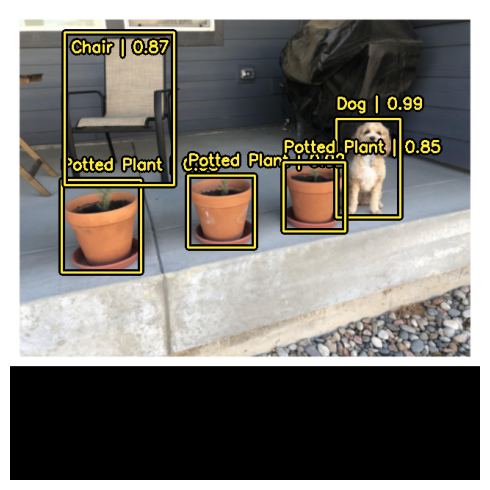

In [9]:
# в метод predict() передаем обработанный тензор изображения
# тензор изображения обрабатывается с помощью предобученной модели
# на выходе получаем предсказанный словарь тензоров
y_pred = pretrained_model.predict(image_batch)
# словарь y_pred содержит следующие тензоны:
# {"classes": ..., boxes": ..., confidence: ..., num_detections: ...} - подробное описание ниже в тексте
# визуализация объектных рамок на картинке
visualization.plot_bounding_box_gallery(
    image_batch, # обработанное изображение
    value_range=(0, 255), # диапазон значений пикселей
    rows=1, # количество строк в галерее на выходе
    cols=1, # количество столбцов в галерее на выходе
    y_pred=y_pred, # указатель на тензор с предсказанными данными, на основе него строим рамки на выходном рисунке
    scale=5, # масштаб изображения
    font_scale=0.7, # размер шрифта
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами объектов, для обозначения их на выходном рисунке
)
y_pred # вывод на экран тензора, для того чтобы понять как он выглядит, ниже

Переменная y_pred - это словарь, в котором каждый элемент содержит тензоры, т.е. массивы с параметрами.
В нашем случае, словарь содержит следующие тензоры:
boxes:содержит 5 массивов с параметрами конкретной объектной рамки, каждый массив имеет 4 значения - x, y, w(idth), h(ight)
confidence: уровень уверенности, в том что конкретная рамка является тем, чем ее распознали (относительный параметр)
classes - индексы (номера) распознанных классов объектов
num_detections - количество найденных классов

Распознаем другую картинку, с техникой:

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


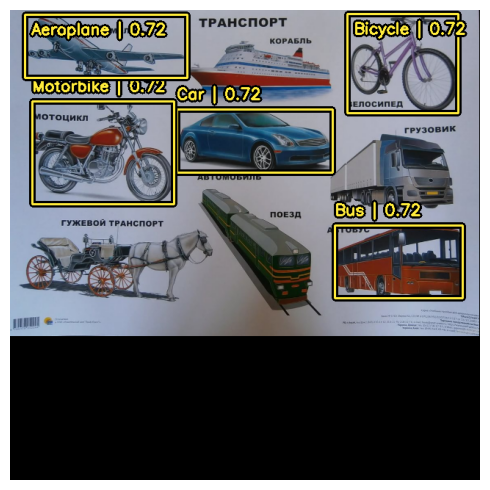

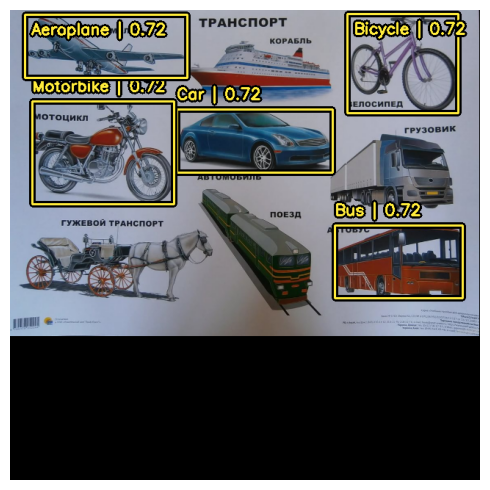

In [29]:
# указываем путь к картинке с техникой в интернете
file2 = keras.utils.get_file(origin="https://stihi.ru/pics/2019/03/20/1028.jpg")
# скачаем и переведем картинку в матрицу с помощью средств Кераса
image2 = np.array(keras.utils.load_img(file2))
# зададим конвейер для обработки картинки
image_batch2 = inference_resizing([image2])
# распознаем картинку и результат помещаем в тензор
y_pred = pretrained_model.predict(image_batch2)
# визуализируем объектные рамки на картинке
visualization.plot_bounding_box_gallery(
    inference_resizing([image2]), # обработанная картинка
    value_range=(0, 255), # диапазон значений пикселей
    rows=1, # кол-во строк в визуализации
    cols=1, # кол-во столбцов в визуализации
    y_pred=y_pred, # указатель на тензор
    scale=5, # масштаб
    font_scale=0.7, # размер шрифта
    bounding_box_format="xywh", # объектные рамки
    class_mapping=class_mapping, # указываем наш словарь с классами
)

Не все объекты с техникой обнаружены, исправим далее.

Для поддержания простоты во входном потоке, KerasCV применяет метод подавления немаксимумов (NMS) в классе YOLOV8Detector. Метод подавления немаксимумов - традиционный компьютерный алгоритм, который решает задачу обнаружения моделью множества рамок для одного и того же объекта.

Подавление немаксимумов хорошо настраиваемый алгоритм, вам в большинстве случаев нужно будет лишь указать аргументы для метода немаксимумов. Это можно сделать с помощью переопределения аргумента prediction_decoder.

Для демонстрации такой концепции, давайте временно отключим подавление немаксимумов в нашей модели YOLOV8Detector.
Это можно сделать, дописав атрибут prediction_decoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


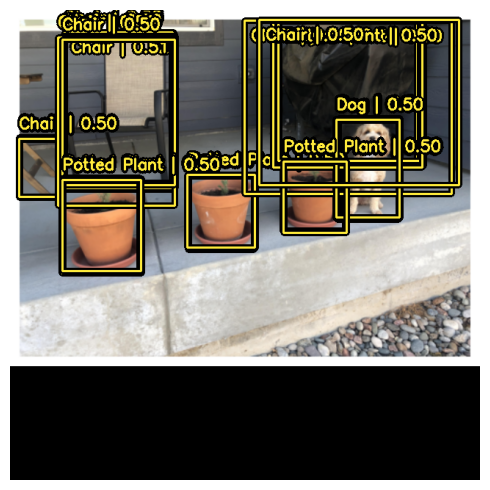

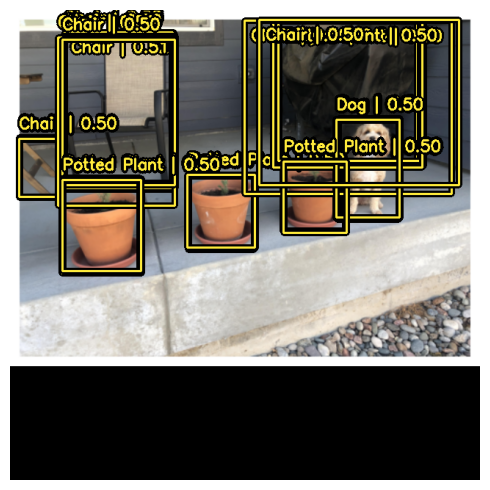

In [30]:
# Метод NonMaxSuppression слой предназначен для регулирования подавления немаксимумов
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh", # формат рамок
    from_logits=True, # отключаем использование в этом слое функций активации
    iou_threshold=1.0, # значение данного порога равное единице, означает полно отключение подавление немаксимумов
    confidence_threshold=0.0, # порог уровня уверенности равную нулю, позволяет отобразить все предполагаемые объектные рамки
)
# предобученная модель YOLO
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # конкретный тип модели YOLO, обученной на наборе данных Pascal VOC
    bounding_box_format="xywh", # формат объектных рамок
    prediction_decoder=prediction_decoder, # указатель на слой декодера без подавления немаксимумов
)
# получаем тензор от предобученной модели
y_pred = pretrained_model.predict(image_batch)
# визуализируем картинки с объектными рамками
visualization.plot_bounding_box_gallery(
    image_batch, # обработанная картинка
    value_range=(0, 255), # диапазон значений пикселей
    rows=1, # кол-во строк в галерее
    cols=1, # кол-во столбцов в галерее
    y_pred=y_pred, # указатель на тензор с предсказанными значениями
    scale=5, # масштаб
    font_scale=0.7, # размер шрифта
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами
)

После полного подавления немаксимоумов, получаем все возможные варианты объектных рамок на изображении
Посмотрим на подавление немаксимумов на картинке с техникой

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


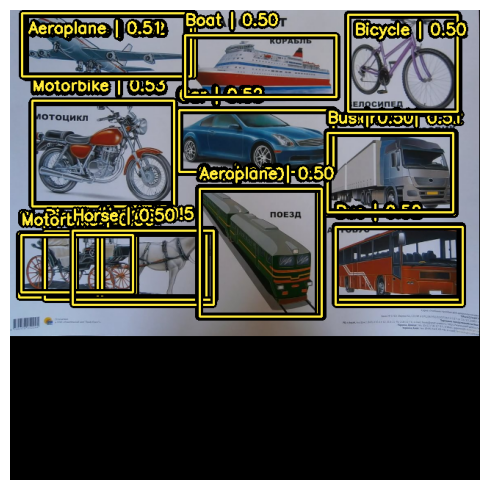

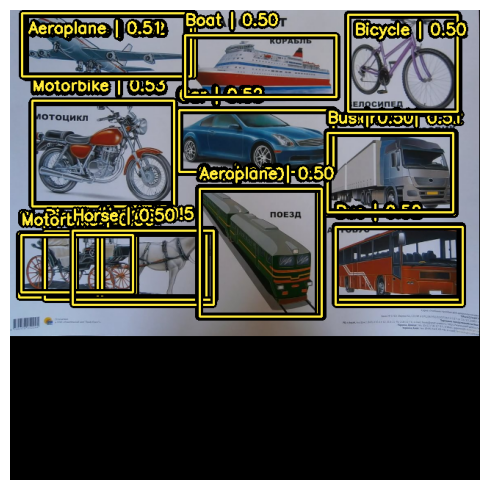

In [31]:
# тензор предсказаний для второй картинки с техникой
y_pred = pretrained_model.predict(image_batch2)
# визуализация картинки с рамками
visualization.plot_bounding_box_gallery(
    image_batch2, # обработанная картинка
    value_range=(0, 255), # значения пикселей
    rows=1, # кол-во строк
    cols=1, # кол-во столбцов
    y_pred=y_pred, # указатель на тензор
    scale=5, # масштаб картинки
    font_scale=0.7, # размер шрифта
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами
)

Далее, давайте перенастроим keras_cv.layers.NonMaxSuppression для нашего примера! Мы настроим параметр iou_threshold на 0.2 и параметр confidence_threshold на 0.7.

Увеличение значение параметра confidence_threshold, влияет на модель так, что на выходе будут объектные рамки с более высоким уровнем доверия.

iou_threshold - контролирует порог "пересечения над слиянием" (IoU), который будет таким, чтобы из двух рамок осталась только одна. Более подробное описание данного параметра смотрите в документации TensorFlow API docs

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


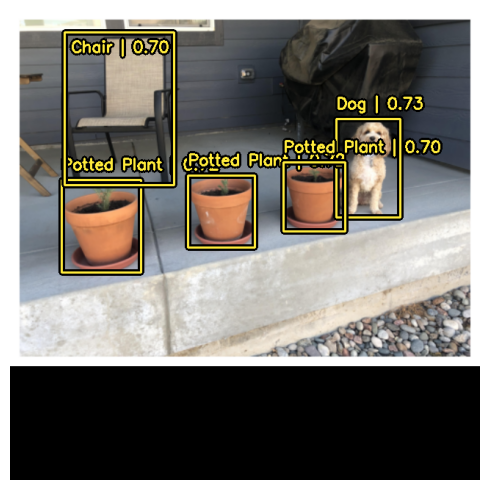

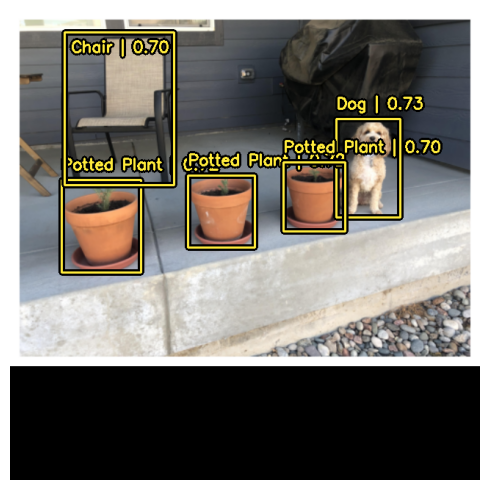

In [32]:
# слой NonMaxSuppression, позволяет контролировать подавление немаксимумов
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh", # формат объектных рамок
    from_logits=True, # применение логитов, позволяет обойтись без функции активации в данном слое.
    iou_threshold=0.2, # уменьшая порог IOU, отсекаем плохо распознаные объекты
    confidence_threshold=0.7, # настройка порога уверенности позволяет контролировать подавление немаксимумов
)
# получаем настройки предобученной модели YOLO
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # модель YOLO, предобученная на картинках из набора Pascal VOC
    bounding_box_format="xywh", # формат объектных рамок
    prediction_decoder=prediction_decoder, # тип декодера, в нашем случае, он определен выше - подавление немаксимумов
)
# получаем тензоры предсказаний
y_pred = pretrained_model.predict(image_batch)
# визуализации объектных рамок
visualization.plot_bounding_box_gallery(
    image_batch, # указатель на обработанную картинку
    value_range=(0, 255), # диапазон пикселей картинки
    rows=1, # кол-во строк
    cols=1, # кол-во столбцов
    y_pred=y_pred, # указатель на тензор с предсказанными параметрами
    scale=5, # масштаб картинки
    font_scale=0.7, # размер шрифтов
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами объектов
)

Настроим пороги для картинки с техникой так, чтобы одному объекту соответствовала одна рамка

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


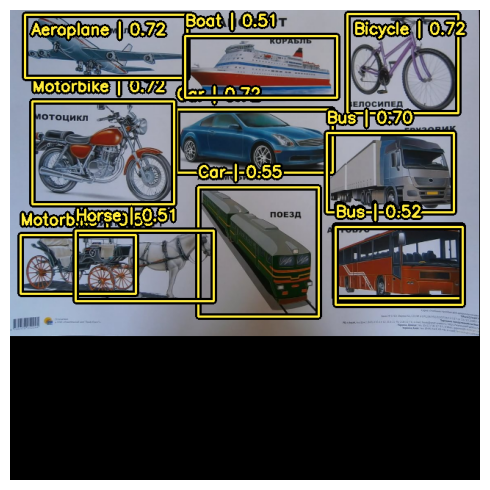

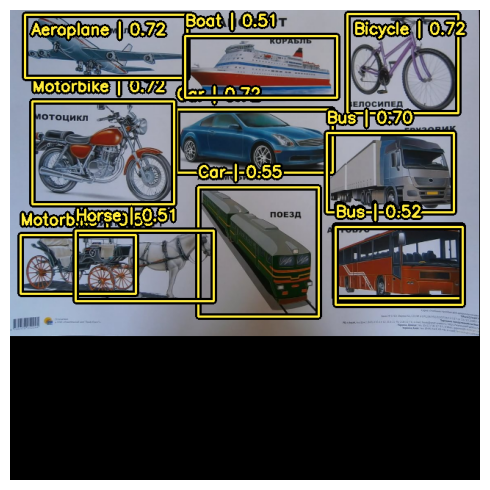

In [33]:
# слой NonMaxSuppression, позволяет контролировать подавление немаксимумов
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh", # формат объектных рамок
    from_logits=True, # применение логитов, позволяет обойтись без функции активации в данном слое.
    iou_threshold=0.9, # уменьшая порог IOU, отсекаем плохо распознаные объекты
    confidence_threshold=0.51, # настройка порога уверенности позволяет контролировать подавление немаксимумов
)
# получаем настройки предобученной модели YOLO
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # модель YOLO, предобученная на картинках из набора Pascal VOC
    bounding_box_format="xywh", # формат объектных рамок
    prediction_decoder=prediction_decoder, # тип декодера, в нашем случае, он определен выше - подавление немаксимумов
)
# получаем тензоры предсказаний
y_pred = pretrained_model.predict(image_batch2)
# визуализации объектных рамок
visualization.plot_bounding_box_gallery(
    image_batch2, # указатель на обработанную картинку
    value_range=(0, 255), # диапазон пикселей картинки
    rows=1, # кол-во строк
    cols=1, # кол-во столбцов
    y_pred=y_pred, # указатель на тензор с предсказанными параметрами
    scale=5, # масштаб картинки
    font_scale=0.7, # размер шрифтов
    bounding_box_format="xywh", # формат объектных рамок
    class_mapping=class_mapping, # указатель на словарь с классами объектов
)

В итоге каждому объекту соответствует одна рамка.
При порогах: iou=0.9 и уверенности=0.51

## Обучение нестандартных моделей

Не важно, любитель ли вы в области обнаружения объектов, либо уже ветеран, сборка конвейера по обнаружению объектов с нуля, будет являться сложным делом, в любом случае. К счастью, все интерфейсы по обнаружению объектов в KerasCV построены по модульному принципу. Не важно, нужен ли вам готовый контейнер, либо просто модель по обнаружению, либо просто механизм преобразования формата из xywh в форматxyxy, KerasCV все это осилит.

В данном руководстве, мы собираем полностью обучаемый конвейер для модели обнаружения объектов на основе KerasCV. Включая загрузку данных, аугментацию, расчет метрик и вывод!

Для начала, давайте разберемся со всеми входными данными и зададим глобальные параметры.

In [34]:
BATCH_SIZE = 4

# загрузка данных

Давайте определим форматы для загрузки и объектных рамок. KerasCV имеет предопределенный формат для рамок. Чтобы все это скомпоновать вместе, необходимо упаковать параметры рамок в словарь, как описано ниже:

bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
bounding_boxes['boxes'] содержит координаты рамок в формате boun ding_box_format поддерживаемым KerasCV.

KerasCV требует, чтобы аргумент bounding_box_format содержал все параметры, относящиеся к объектным рамкам. Это сделано для увеличения ваших возможностей по включению индивидуальных параметров в конвейер, также, позволяя коду быть самодокументированным на протяжении всего конвейера.

Что бы соответствовать стилю API KerasCV, рекомендуется задать загрузчик данных, используя аргумент bounding_box_format. Тогда тем, кто будет использовать ваш загрузчик данных, будет понятно, какой формат используется.

В этом примере, мы задаем формат для рамок вида xywh.

Пример:

train_ds, ds_info = your_data_loader.load(
    split='train', bounding_box_format='xywh', batch_size=8
)
Это задаст точный формат для рамок вида xywh. Об этом подробнее можно почитать в документации KerasCV в разделе формат рамок in the API docs.

Наши данные загружаются в формате {"images": images, "bounding_boxes": bounding_boxes}. Данный формат поддерживается всеми предварительными компонентами KerasCV.

Давайте загрузим данные и проверим, что данные выглядят как ожидается.

In [41]:
# функция визуализации данных
# на вход поступают аргументы: датасет, диапазон пикселей, кол-во строк, кол-во колонок, формат рамок
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1))) # создание итерируемого объекта из словаря тензоров картинки
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"] # призвоения соответсвующим переменным тензоров из словаря данных
    visualization.plot_bounding_box_gallery( # функция прорисовки картинок
        images, # тензор изображения
        value_range=value_range, # диапазон пикселей
        rows=rows, # кол-во строк
        cols=cols, # кол-во колонок
        y_true=bounding_boxes, # тензор предсказаний
        scale=5, # масштаб
        font_scale=0.7, # размер шрифта
        bounding_box_format=bounding_box_format, # формат объектных рамок
        class_mapping=class_mapping, # словарь объектных классов
    )

# функция распаковки (преобразования) "сырых" (необработанных) данных
def unpackage_raw_tfds_inputs(inputs, bounding_box_format): # на входе элементы словаря, и формат данных
    image = inputs["image"] # значение словаря по ключ image присваиваем переменной image
    # переменной рамок boxes присваивается конвертированное значения в соответствии с переданным форматом
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image, # текущая картинка переданная из функции load_pascal_voc
        source="rel_yxyx", # исходный относительный формат
        target=bounding_box_format, # конечный заданный формат
    )
    bounding_boxes = { # словарь формата объектных рамок
        "classes": inputs["objects"]["label"], # классы
        "boxes": boxes, # рамки
    }
    # возвращает словарь содержащий картинки и их форматы
    return {"images": image, "bounding_boxes": bounding_boxes}

# функция загрузки данных
def load_pascal_voc(split, dataset, bounding_box_format):
    # процедура загрузки сырых данных, с разбиением на части с тусованием
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    # структуризация данных по заданному формату с помощью параметра bounding_box_format
    ds = ds.map(
        # каждый элемент набора данных обрабатывается функцией unpackage_raw_tfds_inputs, возвращающей словарь
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        # настройка производительности - параллельные вычисления
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds # возвращаем датасет

# Загружаем тренировочные данные
train_ds = load_pascal_voc(split="train", # параметр, указывающий какую часть данных загрузить: train, test или val
                           dataset="voc/2007", # указываем тип и версия набора данных
                           bounding_box_format="xywh") # формат объектных рамок
# Загружаем тестовые данные
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")
# сокращаем размер тестовых данных в 10 раз
eval_ds = eval_ds.take(len(eval_ds)//200)
# Загружаем валидационные данные
val_ds = load_pascal_voc(split="validation", dataset="voc/2007", bounding_box_format="xywh")
print(f"{len(train_ds)=}, {len(eval_ds)=}, {len(val_ds)=}")
# "Тусуем" (перемешиваем) тренировочные данные блоками, в блоке 16 единиц данных
train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

RecursionError: maximum recursion depth exceeded while calling a Python object

Ошибка связанна с маленьким количеством оп у ноутбукаю рекомендую продолжать в гугл колаб.

Далее, давайте разобьем наши данные на пакеты.

В KerasCV для задач обнаружения объектов, пользователям рекомендуется применять разбиение данных на пакеты. Данный подход хорошо работает с изображениями разных размеров из датасета PascalVOC и даже с разным количеством объектных рамок на картинках.

Чтобы разбить датасет на пакеты в конвейере tf.data, можно использовать метод ragged_batch().

In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, # разбиваем тренировочные данные на пакеты по 4 элемента
                                 drop_remainder=True) # отбрасывать не полные пакеты
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, # разбиваем тестовые данные на пакеты по 4 элемента
                               drop_remainder=True) # отбрасывать не полные пакеты
val_ds = val_ds.ragged_batch(BATCH_SIZE, # разбиваем валидационные данные на пакеты по 4 элемента
                               drop_remainder=True) # отбрасывать не полные пакеты

Давайте удостоверимся, что наш датасет соответствует ожидаемому формату KerasCV. Используя функцию visualize_dataset(), вы можете проверить, что ваши данные в том формате, который ожидает KerasCV. Если объектные рамки не видны, или видны в ошибочных местах, это верный признак того, что данные используют неправильный формат.

In [ ]:
visualize_dataset( # функция визуализация тренировочного набора данных, описана выше
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

И для тестового набора:

In [ ]:
visualize_dataset( # Визуализация тестового набора данных
    eval_ds, # тестовый набор данных
    bounding_box_format="xywh", # формат данных
    value_range=(0, 255), # диапазон значений пикселей
    rows=2, # количество картинок в строке
    cols=2, # количество столбцов в строке
    # Если эксперимент запускается не на локальной машине, можно также
    # указать через функцию `visualize_dataset()` вывод в файл с помощью переменной `path`:
    # path="eval.png"
)

Визуализация валидационного набора данных

In [ ]:
visualize_dataset( # Визуализация валидационного набора данных
    val_ds, # тестовый набор данных
    bounding_box_format="xywh", # формат данных
    value_range=(0, 255), # диапазон значений пикселей
    rows=2, # количество картинок в строке
    cols=2, # количество столбцов в строке
    # Если эксперимент запускается не на локальной машине, можно также
    # указать через функцию `visualize_dataset()` вывод в файл с помощью переменной `path`:
    # path="eval.png"
)

Похоже на то, что все структурировано, как и ожидалось. Теперь мы можем перейти к процессу создания конвейера аугментации данных.

# Аугментация данных

Одной из сложнейших задач в процессе создания конвейера по обнаружению образов, является аугментация данных. Техника аугментации изображения должна учитывать характеристики объектных рамок и с ними должны происходить соответствующие изменения.

К счастью, KerasCV поддерживает аугментацию объектных рамок, используя расширенную библиотеку data augmentation layers.

Далее код загружает набор данных Pascal VOC, и на лету применяет, дружелюбную для объектных рамок аугментацию данных внутри конвейера tf.data.

In [ ]:
# список который будет содержать аугментированные изображения
augmenters = [ # с помощью слоев кераса осуществляем предобработку изображений
    # случайное горизонтальное отражение картинки по формату xywh
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    # изменение размера до заданного, причем случайно могут быть увеличина на 75% и уменьшены на 30%
    keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

# функция в виде переменной которой передан список
augmenter_fn = create_augmenter_fn(augmenters)

# обучающие данные подвергаем аугментации с поомщью функции augmenter_fn, используя параллельные вычисления
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
# визуализация аугментированных данных
visualize_dataset(
    train_ds, # аугментированные обучающие данные
    bounding_box_format="xywh", # формат рамки
    value_range=(0, 255), # диапазон значений пикселей
    rows=2, # две строки картинок
    cols=2 # две колонки картинок
)

Великолепно! У нас сейчас есть дружелюбный к рамкам конвейер для аугментации данных. Давайте зададим соответствующий формат для оценочных данных.
Вместо использования метода JitteredResize, давайте используем более понятный для нашего слоя метод keras_cv.layers.Resizing().

In [ ]:
# функция в качестве переменной с помощью слоя керас изменяет размеры картинки до нужного и делает паддинг
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
# тестовые данные аугментируются с помощью функции inference_resizing, используя параллельные вычисления
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

In [ ]:
# валиадционные данные аугментируются с помощью функции inference_resizing, используя параллельные вычисления
val_ds = val_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

Операция изменения размера тренировочных данных, использующая метод JitteredResize(), отличается от аналогичной операции над выходным набором данных, использующим метод layers.Resizing(pad_to_aspect_ratio=True).

Хорошей практикой является визуализация и сравнение обоих датасетов:

In [ ]:
# визуализация тестового датасета
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Наконец, давайте распакуем наш входной словарь, и подготовим его на ввод в нашу модель. В соответствии с аппаратной архитектурой типа TPU, тензоры должны быть плотными (Dense), в противоположность неупорядоченным (Ragged).

Плотный тензор - тип данных фиксированной длины
Неупорядоченный тензор - тип данных переменной длины

In [ ]:
# функция перевода словаря в кортеж
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense( # метод перевода объектных рамок в фиксированный тип данных
        inputs["bounding_boxes"], max_boxes=32
    )

# перевод обучающих данных в кортеж фиксированной длинны где первый элемент картинка, воторой рамки
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
# тоже что верхняя строка но для тестовых данных, обе строки используют параллельную обработку
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
# тоже что верхняя строка но для валидационных данных, обе строки используют параллельную обработку
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
# предзагрузка данных, т.е. такой формат данных,
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
# который позволяет при обработке загружать следующую порцию данных для ускорения процесса обработки
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)
# который позволяет при обработке загружать следующую порцию данных для ускорения процесса обработки
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Оптимизатор

В этом руководстве, мы используем стандартный оптимизатор SGD (стохастический градиентный спуск) и обратные вызовы keras.callbacks.ReduceLROnPlateau для контроля скорости обучения.

Вы должны всегда включать параметр global_clipnorm когда обучаете модель по обнаружению объектов. Это исключит проблему "градиентного взрыва", которая не редка при обучении моделей по обнаружению объектов.

In [ ]:
# переменная скорости обучения
base_lr = 0.01
# функция оптимизации
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, # скорость обучения
    momentum=0.5, # параметр учитывающий в моменте процесс обучения, помогает ускориь процесс обучения
    # Важно! Задавайте всегда переменную global_clipnorm
    # это глобальная норма градиентов, т.е. все градиенты будут ограничены нормой равной десяти
    global_clipnorm=5.0
)

Чтобы достичь наилучшего результата с вашим набором данных, вы должны вручную задать расписание скорости обучения PiecewiseConstantDecay. Расписания PiecewiseConstantDecay призваны улучшать производительность, но их нельзя использовать в других задачах.

# Функции потерь

Возможно, вы не знакомы с потерями типа "ciou". Они совсем не часто используются в других моделях, но в задачах по обнаружению объектов их иногда применяют.

Вкратце, "Complete IoU" функция потерь, использует метод "пересечения над объединением" и часто выбирается из-за своих свойств сходимости.

В KerasCV, вы можете использовать эту функцию потерь просто задав строковое значение "ciou" в методе compile().

Мы также применяем и стандартные бинарные кросс-энтропийные функции при потерях в классификациях.

In [ ]:
# сборка предобученной модели сети
pretrained_model.compile(
    classification_loss="binary_crossentropy", # функция потерь для классификации
    box_loss="ciou", # функция потерь для предсказаний
)

# Расчет метрик

Популярнейшая метрика по обнаружению объектов это COCO, которая была опубликована вместе с набором данных MSCOCO. KerasCV предоставляет легкий в использовании набор метрик СОСО внутри метода keras_cv.callbacks.PyCOCOCallback.

Примечательно, что мы используем обратные вызовы Keras вместо его метрик, для расчета метрик COCO. Это все потому, что для расчета метрик COCO требуется сохранять в памяти все предсказания модели, для всех вычислений, по конкретному набору данных, что совсем не практично во время обучения

In [ ]:
# обратный вызов дл оценки модели
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds, # количество записей из датасета, после которого происходит оценка
    bounding_box_format="xywh" # формат данных
)

Наш конвейер данных подготовлен! Мы можем приступить к созданию модели и к ее обучению.

# Создание модели

Далее, используем KerasCV API для создания предобученной модели YOLOV8Detector. В этом учебном материале мы применяем предобученную модель, использующей сеть ResNet50 на наборе данных imagenet.

KerasCV делает более легким процесс создания модели YOLOV8Detector с любыми каркасоми на основе KerasCV.

Просто используйте одну из готовых архитектур какую захотите!

Пример:

In [ ]:
# загрузка предобученной модели, которая будет основой другой модели YOLO
model3 = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet", # модель ResNet50, обученная на датасете ImageNet
    bounding_box_format="xywh", # формат объектных рамок
    num_classes=20, # количество моделей в классе
)

Это все что нужно для построения модели YOLOv8 в KerasCV. YOLOv8 принимает кортежи цельных изображений тензора и словари объектных рамок для методов fit() и train_on_batch().

Это соответствует тому, что мы сконструировали для подачи на конвейер данных выше.

# Обучение нашей модели

Все что осталось сделать это обучить нашу модель. Модели обнаружения объектов KerasCV следуют стандарту потока Keras, применяя методы compile() и fit().

Давайте соберем нашу модель:

In [ ]:
# сборка недобученной модели
model3.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

Если хотите полностью обучить модель, удалить .take(20) из всех ссылок на набор данных (ниже и в инициализирующих метриках обратного вызова).

In [ ]:
%%time
# Дообучение предобученной модели на наших данных
history = model.fit(
    train_ds, # подвыборка из датасета
    epochs=11, # Запуск 10-35~ эпох для достижения хороших показателей.
    callbacks=[coco_metrics_callback], # обратный вызов для контроля
)
model3.save("model3.h5")

# Заключительное отображение результатов

KerasCV позволяет легко вывести результат обнаружения объектов . model.predict(images), содержащий тензор объектных рамок. По умолчанию, метод YOLOV8Detector.predict() произведет операцию подавление немаксимумов для вас.

В секции keras_cv, мы будем использовать полученную ранее, предобученную модель:

In [ ]:
# модель на основе предустановленной модели yolo_v8_m_pascalvoc"
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # указание на модель
    bounding_box_format="xywh" # формат данных
)

Далее, для удобства мы соорудим набор с большими пакетами:

In [ ]:
# визуализация непакетированных данных
visualization_ds = eval_ds.unbatch()
# визуализация пакетированных данных нефиксированной длины
visualization_ds = visualization_ds.ragged_batch(16)
# визуализация перемешанных данных
visualization_ds = visualization_ds.shuffle(8)

Сделаем простую функцию для отображения нашего вывода:

In [ ]:
# функция визуализации результатов
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1))) # первый итерируемый кортеж из датасета
    y_pred = model.predict(images) # предсказание для картинки
    visualization.plot_bounding_box_gallery( # функция прорисовки картинок
        images, # картинка
        value_range=(0, 255), # значения пекселей
        bounding_box_format=bounding_box_format, # формат
        y_true=y_true, # истинные рамки
        y_pred=y_pred, # предсказанные рамки
        scale=4, # масштаб
        rows=2, # количество строк
        cols=2, # количество колонок
        show=True, # показывать рамки
        font_scale=0.7, # размер шрифта
        class_mapping=class_mapping, # метод классификации
    )

Вам нужно понастраивать параметры метода NonMaxSuppression до визуально привлекательного результата.

In [ ]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh", # формат рамок
    from_logits=True, # предсказания в виде логитов
    iou_threshold=0.5, # порог перекрытия
    confidence_threshold=0.75, # порог уверенности
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

Превосходно! Наконец, еще один полезный шаблон кода, на заметку, визуализация обнаружений keras.callbacks.Callback для мониторинга процесса обучения:

In [ ]:
# класс обратного вызова для оценки процесса обучения
class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_ds
        )

# Заключения и следующие шаги

KerasCV позволяет легко создать конвейеры по обнаружению объектов. В данном руководстве, мы начинали с написания загрузчика данных, используя описание характеристик объектных рамок в KerasCV Далее, мы собрали конвейер данных производственного уровня для аугментации, используя предпроцессные уровни KerasCV с кодом менее 50 строк.

* Компоненты KerasCV по обнаружению объектов могут быть использованы независимо друг от друга, но в тоже время, имеют тесную интеграцию между собой.

* KerasCV позволяет на профессиональном уровне производить аугментацию объектных рамок, обучение модели, визуализацию и подсчет метрик.

Немного заданий для читателя:

добавьте дополнительную технику аугментации для улучшения производительности модели
настройте гиперпараметры и аугментацию данных для получения результатов высокого качества
обучите модель по обнаружению объектов на личном наборе данных
И в заключении небольшой забавный код, для демонстрации мощи API KerasCV!

Пример распознавания сгенерированных кошек с помощью предобученной модели

In [42]:
#слой NonMaxSuppression, позволяет контролировать подавление немаксимумов
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh", # формат объектных рамок
    from_logits=True, # применение логитов, позволяет обойтись без функции активации в данном слое.
    iou_threshold=0.2, # уменьшая порог IOU, отсекаем плохо распознаные объекты
    confidence_threshold=0.7, # настройка порога уверенности позволяет контролировать подавление немаксимумов
)
# получаем настройки предобученной модели YOLO
model2 = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", # модель YOLO, предобученная на картинках из набора Pascal VOC
    bounding_box_format="xywh", # формат объектных рамок
    prediction_decoder=prediction_decoder, # тип декодера, в нашем случае, он определен выше - подавление немаксимумов
)

In [43]:
# демонстрирует использование предобученной модели для обнаружения объектов на изображениях, которые были
# сгенерированы с использованием модели генерации изображений Stable Diffusion V2.
stable_diffusion = keras_cv.models.StableDiffusionV2(512, 512)
# Генерируются изображения с использованием модели
# Stable Diffusion V2 на основе текстовых описаний.
images = stable_diffusion.text_to_image(
    prompt="A zoomed out photograph of a cool looking cat.  The cat stands in a beautiful forest",
    negative_prompt="unrealistic, bad looking, malformed",
    batch_size=4, # 4 картинки
    seed=1231, # зафиксируем случайность
)
# получение закодированных предсказаний от модели
encoded_predictions = model2(images)
# декодироване предсказаний
y_pred = model2.decode_predictions(encoded_predictions, images)
# визуализация в виде галереи
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    y_pred=y_pred,
    rows=2,
    cols=2,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL++-M license at https://github.com/Stability-AI/stablediffusion/blob/main/LICENSE-MODEL
1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1361968152/1361968152 ━━━━━━━━━━━━━━━━━━━━ 246s 0us/step
3464605600/3464605600 ━━━━━━━━━━━━━━━━━━━━ 619s 0us/step


: 

In [ ]:
history_dict = history.history

# Выводим названия метрик
print("Доступные метрики:", list(history_dict.keys()))

# Выводим значения метрик и функции потерь для каждой эпохи
for metric_name, values in history_dict.items():
    print(f"\n{metric_name}:")
    for epoch, value in enumerate(values, start=1):
        print(f"Эпоха {epoch}: {value}")

* loss: Общая функция потерь.
* class_loss: Потери, связанные с классификацией объектов.
* val_AP: Средняя точность обнаружения (Average Precision)  на тестовом наборе данных. Это метрика, которая оценивает качество обнаружения объектов.
* val_AP50: Средняя точность обнаружения при пороге IoU (Intersection over Union) в 0.5.
* val_AP75: Средняя точность обнаружения при пороге IoU в 0.75.
* val_APs, val_APm, val_APl: Средняя точность обнаружения для маленьких, средних и больших объектов соответственно.
* val_ARmax1, val_ARmax10, val_ARmax100: Среднее значение частоты обнаружения при максимальном числе пропусков в одном изображении (1, 10, 100).
* val_ARs: Средняя частота обнаружения (Average Recall) для маленьких объектов на тестовом наборе данных. Это означает, что эта метрика оценивает, насколько успешно модель обнаруживает маленькие объекты.
* val_ARm: Средняя частота обнаружения для средних объектов на тестовом наборе данных.
* val_ARl: Средняя частота обнаружения для больших объектов на тестовом наборе данных.